# Daily cycle

Data access example to plot the daily precipitation cycle

In [1]:
import xarray as xr

Open the virtual data set for hourly (1hr) data interpolated to the regular lon-lat grid (CSAM-4i):

In [2]:
url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/ncml/CORDEX/output/CSAM-4i/UCAN/ECMWF-ERA5/evaluation/r1i1p1f1/UCAN-WRF433/v1/1hr/v20220727/CORDEX_output_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_UCAN-WRF433_v1_1hr_v20220727'
ds = xr.open_dataset(url, chunks = dict(time = 100, lon = 100, lat = 100))
ds

<xarray.Dataset>
Dimensions:    (lon: 676, lat: 451, time: 26308, bnds: 2)
Coordinates:
  * lon        (lon) float64 -75.0 -74.96 -74.92 -74.88 ... -48.08 -48.04 -48.0
  * lat        (lat) float64 -35.0 -34.96 -34.92 -34.88 ... -17.08 -17.04 -17.0
  * time       (time) datetime64[ns] 2018-06-01 ... 2021-06-01
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 dask.array<chunksize=(100, 2), meta=np.ndarray>
    hurs       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    rsds       (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    sfcWind    (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    uas        (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    vas        (time, lat, lon) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                    CF-1.8
    history:                        Thu Jul 14 15:37:45 2022: cdo remap,desti...
    institution:                    Instituto de Fisica de Cantabria, CSIC-Un...
    creation_date:                  2022-07-12-T16:54:19Z
    experiment:                     Evaluation run with ECMWF ERA5 reanalysis...
    experiment_id:                  FPS-SESA
    ...                             ...
    comment:                        Simulation performed at CESGA (https://ww...
    CDO:                            Climate Data Operators version 1.9.8 (htt...
    CORDEX_domain:                  CSAM-4i
    contact:                        meteo@unican.es
    size:                           2147483647
    size_human:                     142.0 GiB

This loaded the full dataset (3 years and all variables) information into `ds`. Variables can be accessed as attributes of this object:

In [3]:
ds.pr

,Array,Chunk
Bytes,29.88 GiB,3.81 MiB
Shape,"(26308, 451, 676)","(100, 100, 100)"
Count,9241 Tasks,9240 Chunks
Type,float32,numpy.ndarray


This is how the common spatial domain looks like (this operation takes some time since some data needs to be retrieved):

CPU times: user 3.26 s, sys: 990 ms, total: 4.25 s
Wall time: 1min 37s


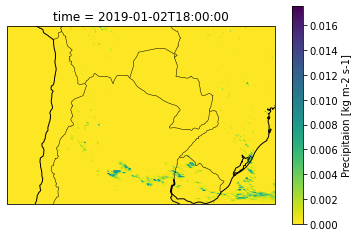

In [4]:
%%time

import cartopy.crs as ccrs
import cartopy.feature as cfea
from matplotlib import cm

p = ds.pr.sel({'time': '2019-01-02 18:00'}).plot(
    transform = ccrs.PlateCarree(),
    #subplot_kws = dict(projection=ccrs.Orthographic(-60, -20)),
    subplot_kws = dict(projection=ccrs.PlateCarree()),
    cmap = cm.viridis_r
)
fa = p.axes.add_feature(cfea.COASTLINE, linewidth=1)
fa = p.axes.add_feature(cfea.BORDERS, linewidth=0.5)

## Extract a single time series

Near Buenos Aires

In [5]:
target_location = dict(lon=-58.48, lat=-34.63)
tseries = ds.pr.sel(target_location, method = 'nearest')
tseries

<xarray.DataArray 'pr' (time: 26308)>
dask.array<getitem, shape=(26308,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 -58.48
    lat      float64 -34.64
  * time     (time) datetime64[ns] 2018-06-01 2018-06-01T01:00:00 ... 2021-06-01
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitaion
    units:          kg m-2 s-1
    cell_methods:   time: mean
    _ChunkSizes:    [168  50  50]

## Compute and plot the daily cycle

CPU times: user 7.13 s, sys: 2.08 s, total: 9.21 s
Wall time: 3min 18s


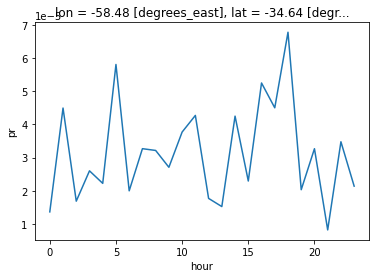

In [6]:
%%time

dly_cycle = tseries.sel(time=tseries.time.dt.season == 'DJF').groupby('time.hour').mean(dim='time').compute()
p = dly_cycle.plot()

## Load observations

Load a virtual dataset prepared for the CORDEX FPS-SESA, interpolatd to the common CSAM-4i grid and aggregating times and variables.

In [7]:
mswx_url = 'https://data.meteo.unican.es/thredds/dodsC/CORDEX/fps/sesa/mswx/CSAM-4i_GloH2O-MSWX_3hr'
obs = xr.open_dataset(mswx_url, chunks = dict(time = 100, lon = 100, lat = 100))
obs

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'tas' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'hurs' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'pr' has multiple fill values {1e+20, '1.e+20f'}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/conventions.py:520: Serializ

,Array,Chunk
Bytes,13.27 GiB,3.81 MiB
Shape,"(11688, 451, 676)","(100, 100, 100)"
Count,4096 Tasks,4095 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,13.27 GiB,3.81 MiB
Shape,"(11688, 451, 676)","(100, 100, 100)"
Count,4096 Tasks,4095 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [8]:
%%time

obs_tseries = obs.pr.sel(target_location, method = 'nearest')
obs_cycle = obs_tseries.sel(time=obs_tseries.time.dt.season == 'DJF').groupby('time.hour').mean(dim='time').compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


CPU times: user 3.11 s, sys: 1.01 s, total: 4.13 s
Wall time: 1min 33s


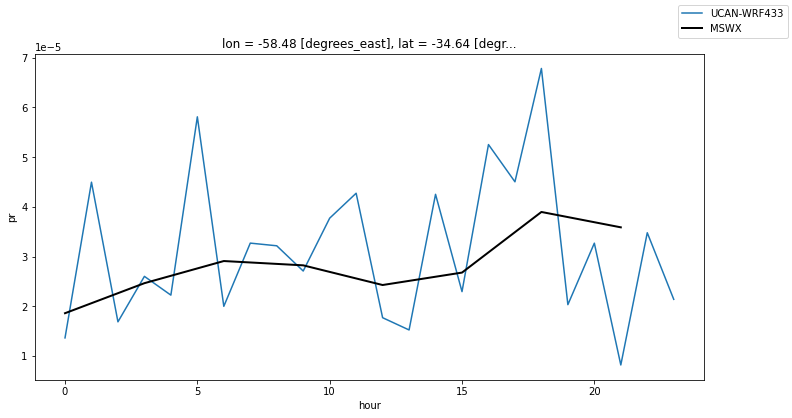

In [9]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
ax = f.gca()
dly_cycle.plot(ax = ax)
obs_cycle.plot(ax = ax, color = 'k', linewidth = 2)
l = f.legend(['UCAN-WRF433', 'MSWX'])